In [1]:
import cv2
import os
import tensorflow as tf
import tensorboard
import keras
from tqdm import tqdm
import numpy as np
from random import shuffle
import time 
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
OUTPUT_PATH = './Dataframes/'
IMG_SIZE = 100

def extract_frames(folder):
    c = 0
    for folders in os.listdir(folder):
        print(folders)
        folder_path = os.path.join(folder, folders)     #"fights/NonViolence/"
        for files in tqdm(os.listdir(folder_path)):           
            path = os.path.join(folder_path, files)     #"fights/NonViolence/NV_1.mp4"
            cap = cv2.VideoCapture(path)
            success = True

            while success:
                success, image = cap.read()
                if not success:
                    break

                cv2.imwrite(OUTPUT_PATH + str(c)+ '.jpg', image)
                c += 1
        print(c)
        print('DONE: '+ folders)

In [8]:
extract_frames('./fights/')

.ipynb_checkpoints


0it [00:00, ?it/s]


0
DONE: .ipynb_checkpoints
NonViolence


100%|██████████| 1000/1000 [39:41<00:00,  2.38s/it] 


127587
DONE: NonViolence
Violence


100%|██████████| 1000/1000 [1:09:57<00:00,  4.20s/it]  

287369
DONE: Violence


In [5]:
# NonViolence
# 127587
# DONE: NonViolence
# Violence
# 287369
# DONE: Violence

In [13]:
#OPTIM = 'SGD'
LR = 0.01
decay = 1e-6
EPOCHS = 25
BATCH_SIZE = 5
LOSS = 'categorical_crossentropy'
NUM_FRAMES = 10
IMG_SIZE = 100

In [3]:
NUM_FRAMES = 10
dataset2 =[]
images = []
dir = "./Dataframes/"
categories = ["NonViolence", "Violence"]
limit = 0
count = 0
for category in categories:
    path = os.path.join(dir, category)
    for frames in tqdm(os.listdir(path)):
        newPath = os.path.join(path, frames)
        img = cv2.imread(newPath)      
        new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # Normalize the image data
        new_img = new_img / 255.0
        images.append(np.array(new_img))
        limit += 1
        count += 1
        if count == NUM_FRAMES:
           count = 0
           if limit < 127587 :
               dataset2.append([images, np.array([1, 0])])
           elif limit >= 127587 :
               dataset2.append([images, np.array([0, 1])])
           images = []

shuffle(dataset2)

100%|██████████████████████████████████████████████████████████████████████████| 159782/159782 [28:34<00:00, 93.17it/s]


In [4]:
import pickle
pickle_out = open("dataset2.npy", "wb")
pickle.dump(dataset2, pickle_out)
#pickle_out = open("y.pickle", "wb")
#pickle.dump(y, pickle_out)

In [1]:
data = np.load('dataset2.npy', allow_pickle = True)


KeyboardInterrupt



In [2]:
train, test = train_test_split(data, train_size = 0.9, shuffle = True)


KeyboardInterrupt



In [6]:
X = np.array([i[0] for i in train]).reshape(-1, 10, IMG_SIZE, IMG_SIZE, 3)
Y = np.array([i[1] for i in train])
x_valid = np.array([i[0] for i in test]).reshape(-1, 10, IMG_SIZE, IMG_SIZE, 3)
y_valid = np.array([i[1] for i in test])

In [7]:
print(Y.shape)
print(y_valid.shape)
print(X.shape)
print(x_valid.shape)

(25862, 2)
(2874, 2)
(25862, 10, 100, 100, 3)
(2874, 10, 100, 100, 3)


In [8]:
print(y_valid[7])

[0 1]


In [15]:
print(dataset[0])

[array([[253, 253, 255, ..., 248, 252,   1],
       [190, 178, 152, ...,  63,  65,   3],
       [189, 175, 138, ...,  75,  68,   2],
       ...,
       [  4,   8,  12, ...,  11,  15,   3],
       [  0,   1,   2, ...,  13,  16,   3],
       [122, 126, 125, ..., 133, 126,   5]], dtype=uint8), 1]


In [14]:
##MODEL CREATION
from tensorflow.keras.layers import (LSTM, Bidirectional, Conv2D, Dense, Flatten, MaxPooling2D, TimeDistributed, 
Reshape, MaxPooling3D)
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(10, IMG_SIZE, IMG_SIZE, 3), padding='same'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling3D((1, 2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling3D((1, 2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling3D((1, 2, 2)))
#model.add(Reshape((10,6400)))
model.flatten()
#BiLSTM layer
lstm_fw = LSTM(units= 32)
lstm_bw = LSTM(units= 32, go_backwards = True)
model.add(Bidirectional(lstm_fw, backward_layer= lstm_bw))

#Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 10, 100, 100, 64)  1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 98, 98, 64)    36928     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 49, 49, 64)   0         
 3D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 47, 47, 64)    36928     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 23, 23, 64)   0         
 3D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 21, 21, 64)   

In [15]:
opt = keras.optimizers.Adam(learning_rate=LR)
model.compile(loss=LOSS, optimizer= opt, metrics=['accuracy'])
#Name = 'CNN-BilSTM{}'.format(int(time.time()))

#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [11]:
model.fit(X,Y,epochs=10,validation_data=(x_valid,y_valid),batch_size=16, verbose=1)

Epoch 1/10
1617/1617 [==============================] - 10743s 7s/step - loss: 0.6858 - accuracy: 0.5521 - val_loss: 0.6854 - val_accuracy: 0.5598
Epoch 2/10
1617/1617 [==============================] - 14044s 9s/step - loss: 0.6865 - accuracy: 0.5539 - val_loss: 0.6908 - val_accuracy: 0.5605
Epoch 3/10
1617/1617 [==============================] - 11165s 7s/step - loss: 0.6866 - accuracy: 0.5553 - val_loss: 0.6890 - val_accuracy: 0.5609
Epoch 4/10
1617/1617 [==============================] - 11911s 7s/step - loss: 0.6881 - accuracy: 0.5548 - val_loss: 0.6853 - val_accuracy: 0.5605
Epoch 5/10
1617/1617 [==============================] - 11235s 7s/step - loss: 0.6862 - accuracy: 0.5537 - val_loss: 0.6879 - val_accuracy: 0.5609
Epoch 6/10
1617/1617 [==============================] - 11016s 7s/step - loss: 0.6876 - accuracy: 0.5570 - val_loss: 0.6871 - val_accuracy: 0.5633
Epoch 7/10
1617/1617 [==============================] - 10708s 7s/step - loss: 0.6871 - accuracy: 0.5549 - val_loss: 0

In [16]:
model.fit(X,Y,epochs=EPOCHS,validation_data=(x_valid,y_valid),batch_size=BATCH_SIZE, verbose=1) #, callbacks=[tensorboard])

Epoch 1/25
5173/5173 [==============================] - 4945s 955ms/step - loss: 0.6839 - accuracy: 0.5504 - val_loss: 0.6689 - val_accuracy: 0.5609
Epoch 2/25
5173/5173 [==============================] - 4248s 821ms/step - loss: 0.6697 - accuracy: 0.5682 - val_loss: 0.6621 - val_accuracy: 0.5901
Epoch 3/25
5173/5173 [==============================] - 4212s 814ms/step - loss: 0.6646 - accuracy: 0.5912 - val_loss: 0.6738 - val_accuracy: 0.5752
Epoch 4/25
5173/5173 [==============================] - 4207s 813ms/step - loss: 0.6650 - accuracy: 0.5908 - val_loss: 0.6604 - val_accuracy: 0.5821
Epoch 5/25
5173/5173 [==============================] - 4181s 808ms/step - loss: 0.6631 - accuracy: 0.5932 - val_loss: 0.6614 - val_accuracy: 0.5807
Epoch 6/25
5173/5173 [==============================] - 4170s 806ms/step - loss: 0.6626 - accuracy: 0.5913 - val_loss: 0.6637 - val_accuracy: 0.5905
Epoch 7/25
5173/5173 [==============================] - 4180s 808ms/step - loss: 0.6632 - accuracy: 0.5914

90/90 [==============================] - 121s 1s/step


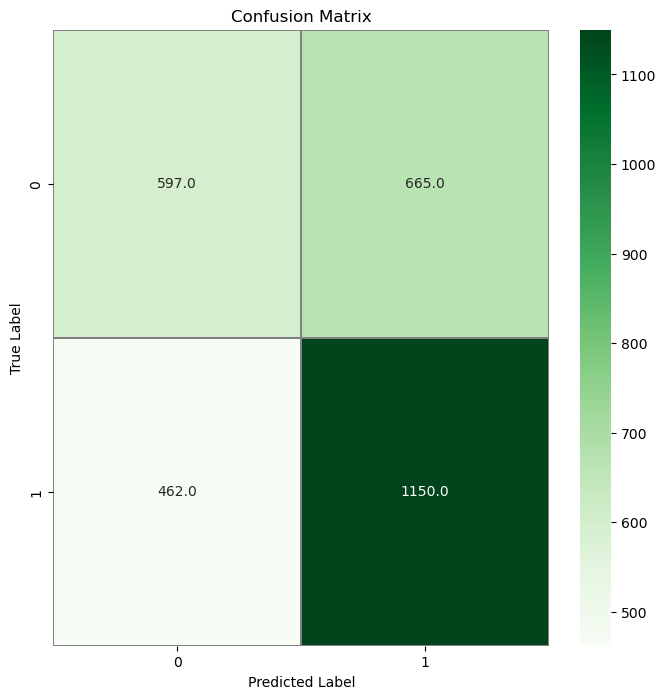

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# confusion matrix
Y_pred = model.predict(x_valid)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_valid,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = pyplot.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
pyplot.xlabel("Predicted Label")
pyplot.ylabel("True Label")
pyplot.title("Confusion Matrix")
pyplot.show()

In [51]:
model_evaluation_history = model.evaluate(x_valid, y_valid)

90/90 [==============================] - 124s 1s/step - loss: 0.6511 - accuracy: 0.6079


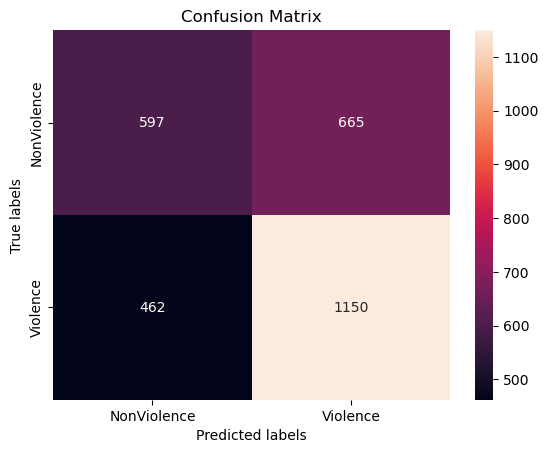

In [61]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= pyplot.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NonViolence', 'Violence']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [62]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.56      0.47      0.51      1262
           1       0.63      0.71      0.67      1612

    accuracy                           0.61      2874
   macro avg       0.60      0.59      0.59      2874
weighted avg       0.60      0.61      0.60      2874

